In [59]:
import seaborn as sns


tbd

In [60]:
from pathlib import Path
import json

# Root folder where your nested folders are located
root_folder = Path("../data//dataset_sw+fw")  # replace with your top-level folder

# Recursively find all JSON files
json_files = list(root_folder.rglob("*.json"))

print(f"Found {len(json_files)} JSON files.")

# Example: load each JSON file
for file_path in json_files:
    with open(file_path) as f:
        data = json.load(f)
        # Now you can use 'data', e.g., classify IoT type
        print(f"Loaded {file_path.name}")


Found 658 JSON files.
Loaded CVE-2022-32259.json
Loaded CVE-2019-4640.json
Loaded CVE-2022-38101.json
Loaded CVE-2019-1880.json
Loaded CVE-2022-38625.json
Loaded CVE-2023-45779.json
Loaded CVE-2020-0996.json
Loaded CVE-2018-19234.json
Loaded CVE-2020-2032.json
Loaded CVE-2017-8665.json
Loaded CVE-2022-25291.json
Loaded CVE-2021-36021.json
Loaded CVE-2021-22790.json
Loaded CVE-2021-3485.json
Loaded CVE-2021-28191.json
Loaded CVE-2023-0392.json
Loaded CVE-2020-10831.json
Loaded CVE-2018-6221.json
Loaded CVE-2021-33090.json
Loaded CVE-2022-34471.json
Loaded CVE-2023-30702.json
Loaded CVE-2021-1426.json
Loaded CVE-2016-4741.json
Loaded CVE-2022-24644.json
Loaded CVE-2021-46442.json
Loaded CVE-2021-38634.json
Loaded CVE-2019-7229.json
Loaded CVE-2019-1289.json
Loaded CVE-2023-34937.json
Loaded CVE-2021-26930.json
Loaded CVE-2019-6742.json
Loaded CVE-2023-6321.json
Loaded CVE-2023-35749.json
Loaded CVE-2017-6445.json
Loaded CVE-2019-17190.json
Loaded CVE-2017-9316.json
Loaded CVE-2020-3342.j

Prepare the training dataset (important step)
Use ONLY the CVE description text

In [61]:
def extract_description(cve_json):
    try:
        descs = cve_json["containers"]["cna"].get("descriptions", [])
        if descs:
            return descs[0]["value"]
    except KeyError:
        pass
    return ""


Showing  random CVE description samples:


In [62]:
# Preview sample CVE descriptions to ensure extraction works
import random

sample_files = random.sample(json_files, min(5, len(json_files)))  # pick up to 5 random files

print(f"Showing {len(sample_files)} random CVE description samples:\n")

for path in sample_files:
    with open(path) as f:
        cve_data = json.load(f)
    desc = extract_description(cve_data)
    print(f"{path.name}: {desc[:300]}")
    #print(f"Description: {desc[:300]}")  # show first 300 chars for brevity
    #print("-" * 80)


Showing 5 random CVE description samples:

CVE-2019-9745.json: CloudCTI HIP Integrator Recognition Configuration Tool allows privilege escalation via its EXQUISE integration. This tool communicates with a service (Recognition Update Client Service) via an insecure communication channel (Named Pipe). The data (JSON) sent via this channel is used to import data f
CVE-2021-0462.json: In the NXP NFC firmware, there is a possible insecure firmware update due to a logic error. This could lead to local escalation of privilege with System execution privileges needed. User interaction is not needed for exploitation.Product: AndroidVersions: Android kernelAndroid ID: A-168799695
CVE-2017-3218.json: Samsung Magician 5.0 fails to validate TLS certificates for HTTPS software update traffic. Prior to version 5.0, Samsung Magician uses HTTP for software updates.
CVE-2021-28191.json: The Firmware update function in ASUS BMC’s firmware Web management page does not verify the string length entered by us



Define the label space (fixed & explicit)

In [63]:

LABELS = [
    "Home",
    "SCADA",
    "Enterprise",
    "Mobile",
    "PC",
    "Other"
]

label2id = {l: i for i, l in enumerate(LABELS)}
id2label = {i: l for l, i in label2id.items()}


Convert rule-based output to label ID

In [64]:
def normalize_label(rule_label):
    if "Home" in rule_label:
        return "Home"
    if "SCADA" in rule_label:
        return "SCADA"
    if "Enterprise" in rule_label:
        return "Enterprise"
    if "Mobile" in rule_label:
        return "Mobile"
    if "PC" in rule_label:
        return "PC"
    return "Other"


 Smart Rule-Based with Word Context

In [65]:
# ==================== 4.  RULE-BASED CLASSIFIER ====================
import re
def classify_cve_iot_category(cve):
    """Enhanced rule-based classifier with better keyword coverage"""
    desc = extract_description(cve).lower()
    
    # Expanded keywords based on actual CVE patterns
    patterns = {
        "Home": [
            # Smart home devices
            r"smart\s+(home|thermostat|bulb|lock|speaker|tv|plug|camera|doorbell)",
            r"iot\s+device",
            r"connected\s+device",
            r"home\s+automation",
            # Network devices (home/SOHO)
            r"\b(router|wifi|wireless)\s+(router|access\s+point|device)",
            r"\b(tplink|d-link|asus|netgear|linksys|nest|ring|arlo|wyze|roku)\b",
            # Home security
            r"security\s+camera",
            r"ip\s+camera",
            r"baby\s+monitor",
            # Home entertainment
            r"smart\s+tv",
            r"streaming\s+device",
            r"gaming\s+console",
            # Keywords from your data
            r"\b(soho|home\s+router)\b"
        ],
        
        "SCADA": [
            # Industrial systems
            r"\b(scada|ics|plc|hmi|rtu|dcs)\b",
            r"industrial\s+control",
            r"process\s+control",
            r"supervisory\s+control",
            # Critical infrastructure
            r"power\s+(grid|plant|station)",
            r"water\s+treatment",
            r"\b(oil|gas)\s+.*\s+(plant|refinery|pipeline)",
            # Medical devices
            r"medical\s+device",
            r"patient\s+monitor",
            r"hospital\s+equipment",
            # Manufacturing
            r"\b(manufacturing|factory|plant)\b",
            # Automotive
            r"\b(automotive|vehicle|car)\b",
            r"engine\s+control"
        ],
        
        "Enterprise": [
            # Enterprise context
            r"enterprise\s+(network|system|software|application)",
            r"business\s+(network|application)",
            r"corporate\s+(network|environment)",
            # Cloud and servers
            r"cloud\s+(service|infrastructure|platform)",
            r"data\s+center",
            r"server\s+(software|application|side|hardware)",
            # Networking equipment
            r"\b(switch|firewall|vpn|load\s+balancer)\b",
            # Specific enterprise brands
            r"\b(cisco|juniper|paloalto|fortinet|vmware|oracle|sap|microsoft\s+server)\b",
            # Storage
            r"storage\s+system",
            r"\b(nas|san)\b"
        ],
        
        "Mobile": [
            # Mobile devices
            r"\b(android|ios|iphone|ipad|smartphone|tablet)\b",
            r"mobile\s+(device|phone|application|app|os)",
            # Mobile context
            r"google\s+play",
            r"app\s+store",
            # Wearables
            r"\b(smartwatch|wearable|fitness\s+tracker)\b",
            # Mobile networks
            r"\b(5g|lte|cellular)\b"
        ],
        
        "PC": [
            # Personal computers
            r"\b(pc|computer|desktop|laptop|notebook)\b",
            r"personal\s+computer",
            # Operating systems
            r"\b(windows|linux|macos|ubuntu|debian|centos|red\s+hat)\b",
            r"operating\s+system",
            # PC components
            r"\b(bios|uefi|cpu|gpu|ram|ssd|hard\s+drive|motherboard)\b",
            # PC software
            r"\b(microsoft\s+office|adobe|antivirus|browser)\b",
            # Specific terms from your data
            r"\b(intel\s+nuc|chrome\s+os)\b"
        ]
    }


    # Score categories
    scores = {}
    for category, regex_list in patterns.items():
        score = 0
        for pattern in regex_list:
            matches = re.findall(pattern, desc)
            if matches:
                # Multi-word patterns get higher weight
                if "\\s" in pattern:
                    score += len(matches) * 3
                else:
                    score += len(matches) * 2
        if score > 0:
            scores[category] = score
    
    # Return best match if above threshold
    if scores:
        best_category, best_score = max(scores.items(), key=lambda x: x[1])
        if best_score >= 2:  # Lower threshold to catch more cases
            return best_category
    
    return "Other"

##### Building dataset with rule-based classification...

In [66]:
# ==================== 5. BUILD DATASET ====================
from datasets import Dataset

texts = []
labels = []
rule_predictions = []

for json_file in json_files:
    with open(json_file) as f:
        try:
            cve = json.load(f)
        except json.JSONDecodeError:
            continue
    
    desc = extract_description(cve)
    if desc.strip() == "":
        continue
    
    # Use improved classifier
    rule_label = classify_cve_iot_category(cve)
    label_id = label2id[rule_label]
    
    texts.append(desc)
    labels.append(label_id)
    rule_predictions.append(rule_label)

# Create dataset
dataset = Dataset.from_dict({
    "text": texts,
    "label": labels
})

In [67]:
# ==================== 6. PRINT CLASS DISTRIBUTION ====================
import pandas as pd

print("\n" + "="*50)
print(" Rule-Based Classification Distribution")
print("="*50)

# Desired fixed class order
CLASS_ORDER = ["Home", "SCADA", "Enterprise", "Mobile", "PC", "Other"]

# Create DataFrame
dist_df = pd.DataFrame({
    "IoT_Class": rule_predictions,
    "Label_ID": labels
})

# Count distribution
dist_counts = dist_df["IoT_Class"].value_counts().reindex(CLASS_ORDER, fill_value=0).reset_index()
dist_counts.columns = ["IoT_Class", "Count"]

# Add percentage
dist_counts["Percentage"] = (dist_counts["Count"] / len(dataset) * 100).round(1)

# Print formatted distribution
print("\n IoT Class Distribution:")
print("-" * 35)

for idx, row in dist_counts.iterrows():
    print(f"{idx+1:2d}  {row['IoT_Class']:15s} {row['Count']:5d} ({row['Percentage']}%)")



 Rule-Based Classification Distribution

 IoT Class Distribution:
-----------------------------------
 1  Home               26 (4.0%)
 2  SCADA              16 (2.4%)
 3  Enterprise         43 (6.5%)
 4  Mobile             24 (3.6%)
 5  PC                145 (22.0%)
 6  Other             404 (61.4%)


/tmp/ipykernel_158221/3775126955.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


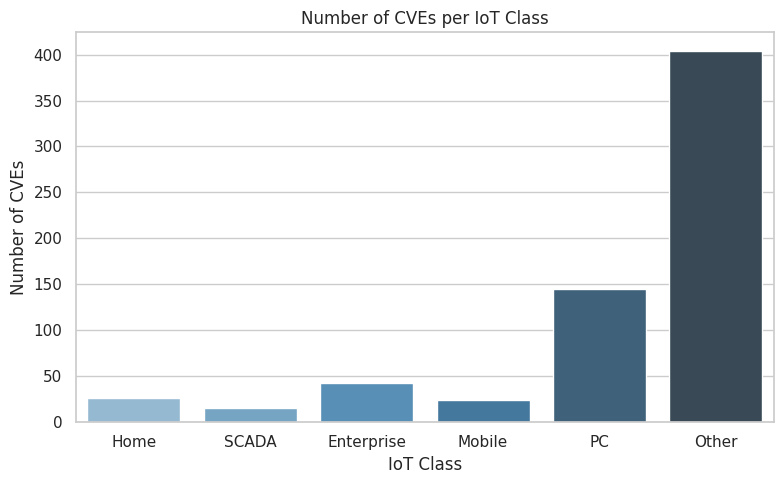

In [68]:
# ==================== PLOT CVE DISTRIBUTION ====================
from matplotlib import pyplot as plt


sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))

# DON'T recreate dist_counts here - it's already calculated above!
# Use the existing dist_counts variable from line 8

sns.barplot(
    data=dist_counts,  # This should use the existing dist_counts
    x="IoT_Class",
    y="Count",
    order=dist_counts["IoT_Class"],  # keep the order from your table
    palette="Blues_d"
)

plt.title("Number of CVEs per IoT Class")
plt.xlabel("IoT Class")
plt.ylabel("Number of CVEs")
plt.xticks(rotation=0)  # rotate if labels are long
plt.tight_layout()
plt.show()

In [69]:
#dist_counts = pd.DataFrame()  # empty, reset for plot 


In [70]:
# ====================   RANDOM DESCRIPTIONS PER CLASS ====================
print(" 3 Random CVE Descriptions per IoT Class")
print("="*50)

for idx, row in dist_counts.iterrows():
    cls = row["IoT_Class"]
    indices = [i for i, l in enumerate(rule_predictions) if l == cls]

    if not indices:
        continue

    random.shuffle(indices)
    print(f"\n{idx+1}. {cls.upper()}")

    for i in indices[:3]:
        cve_name = Path(json_files[i]).name

        with open(json_files[i], "r", encoding="utf-8") as f:
            desc = extract_description(json.load(f))

        print(f" {cve_name}: {desc[:150]}{'...' if len(desc) > 150 else ''}")

 3 Random CVE Descriptions per IoT Class

1. HOME
 CVE-2023-35747.json: D-Link DAP-2622 DDP Firmware Upgrade Auth Password Stack-based Buffer Overflow Remote Code Execution Vulnerability. This vulnerability allows network-...
 CVE-2021-46442.json: In the "webupg" binary of D-Link DIR-825 G1, attackers can bypass authentication through parameters "autoupgrade.asp", and perform functions such as d...
 CVE-2020-15498.json: An issue was discovered on ASUS RT-AC1900P routers before 3.0.0.4.385_20253. The router accepts an arbitrary server certificate for a firmware update....

2. SCADA
 CVE-2019-6842.json: A CWE-755: Improper Handling of Exceptional Conditions vulnerability exists in Modicon M580, Modicon M340, Modicon BMxCRA and 140CRA modules (all firm...
 CVE-2019-6841.json: A CWE-755: Improper Handling of Exceptional Conditions vulnerability exists in Modicon M580 with firmware (version prior to V3.10), Modicon M340 (all ...
 CVE-2019-6843.json: A CWE-755: Improper Handling of Exception

### Adding Vendor and product
##### i think adding keywords from the vendors and products names would improve my rule-based

In [71]:
def extract_vendor_product(cve_json):
    """Extract vendor and product information from CVE JSON"""
    vendor = "Unknown"
    product = "Unknown"
    
    try:
        # Try to get from affected section in cna
        affected = cve_json["containers"]["cna"].get("affected", [])
        if affected:
            vendor = affected[0].get("vendor", "Unknown")
            product = affected[0].get("product", "Unknown")
    except (KeyError, IndexError):
        pass
    
    # Also check adp section if not found
    if vendor == "Unknown":
        try:
            adp = cve_json["containers"].get("adp", [])
            for item in adp:
                affected = item.get("affected", [])
                if affected:
                    vendor = affected[0].get("vendor", "Unknown")
                    product = affected[0].get("product", "Unknown")
                    if vendor != "Unknown":
                        break
        except (KeyError, IndexError):
            pass
    
    return vendor, product

reve

In [72]:
# ==================== 3. PREVIEW DATA WITH VENDOR/PRODUCT INFO ====================
print("\n" + "="*50)
print("Previewing CVE data with vendor/product information")
print("="*50)

import random
sample_files = random.sample(json_files, min(100, len(json_files)))

print(f"\nShowing {len(sample_files)} random CVE samples with vendor/product info:\n")

for path in sample_files:
    with open(path) as f:
        cve_data = json.load(f)
    
    desc = extract_description(cve_data)
    vendor, product = extract_vendor_product(cve_data)
    
    print(f" {path.name}:")
    print(f"   Vendor: {vendor}")
    print(f"   Product: {product}")
    print(f"   Description: {desc[:150]}...")
    print("-" * 80)



Previewing CVE data with vendor/product information

Showing 100 random CVE samples with vendor/product info:

 CVE-2017-6667.json:
   Vendor: n/a
   Product: Cisco Context Service SDK
   Description: A vulnerability in the update process for the dynamic JAR file of the Cisco Context Service software development kit (SDK) could allow an unauthentica...
--------------------------------------------------------------------------------
 CVE-2022-34458.json:
   Vendor: Dell
   Product: Dell Command Update (DCU)
   Description: 
Dell Command | Update, Dell Update, and Alienware Update versions prior to 4.7 contain a Exposure of Sensitive System Information to an Unauthorized ...
--------------------------------------------------------------------------------
 CVE-2022-28751.json:
   Vendor: Zoom Video Communications Inc
   Product: Zoom Client for Meetings for MacOS
   Description: The Zoom Client for Meetings for MacOS (Standard and for IT Admin) before version 5.11.3 contains a vulnerabil

In [73]:
# Define known vendors and products for each category
vendor_categories = {
    "Home": [
        "d-link", "tplink", "asus", "netgear", "linksys", "nest", "ring", "arlo", 
        "wyze", "roku", "google", "amazon", "apple", "samsung", "xiaomi", "philips",
        "hue", "smartthings", "ecobee", "arlo", "eufy", "blink", "simplisafe",
        "logitech", "harman", "sonos", "bose", "jbl", "belkin", "meross", "tuya"
    ],
    "SCADA": [
        "siemens", "rockwell", "schneider", "abb", "emerson", "honeywell", "yokogawa",
        "mitsubishi", "omron", "fanuc", "beckhoff", "wago", "moxa", "advantech",
        "b&r", "panasonic", "delta", "fujitsu", "hitachi", "toshiba", "general electric",
        "ge", "allen-bradley", "modicon", "telemecanique", "square d", "cutler-hammer"
    ],
    "Enterprise": [
        "cisco", "juniper", "paloalto", "fortinet", "checkpoint", "f5", "arista",
        "extreme", "brocade", "hp", "hewlett-packard", "dell", "ibm", "oracle",
        "sap", "vmware", "red hat", "microsoft", "intel", "amd", "nvidia", "qualcomm",
        "broadcom", "marvell", "micron", "sandisk", "seagate", "western digital",
        "synology", "qnap", "netapp", "emc", "hitachi", "huawei", "zte", "ericsson",
        "nokia", "motorola", "aruba", "ruckus", "ubiquiti"
    ],
    "Mobile": [
        "apple", "samsung", "google", "huawei", "xiaomi", "oppo", "vivo", "oneplus",
        "sony", "lg", "motorola", "nokia", "htc", "blackberry", "asus", "lenovo",
        "zte", "alcatel", "realme", "tecno", "infinix", "fairphone", "nothing"
    ],
    "PC": [
        "dell", "hp", "hewlett-packard", "lenovo", "asus", "acer", "msi", "gigabyte",
        "intel", "amd", "nvidia", "microsoft", "apple", "toshiba", "fujitsu", "samsung",
        "lg", "sony", "panasonic", "sharp", "nec", "epson", "brother", "canon", "ricoh",
        "kyocera", "xerox", "lexmark", "okidata", "konica", "minolta"
    ]
}

# Product keywords that indicate specific categories
product_keywords = {
    "Home": [
        "router", "access point", "mesh", "wifi", "camera", "doorbell", "thermostat",
        "bulb", "light", "plug", "outlet", "switch", "lock", "speaker", "display",
        "hub", "gateway", "bridge", "extender", "repeater", "adapter", "dongle"
    ],
    "SCADA": [
        "plc", "hmi", "rtu", "dcs", "scada", "ics", "controller", "automation",
        "drive", "inverter", "servo", "motor", "sensor", "actuator", "valve",
        "transmitter", "recorder", "logger", "monitor", "panel", "station"
    ],
    "Enterprise": [
        "switch", "firewall", "router", "load balancer", "server", "storage",
        "nas", "san", "array", "appliance", "gateway", "proxy", "vpn", "wireless",
        "controller", "management", "console", "director", "orchestrator", "hypervisor"
    ],
    "Mobile": [
        "phone", "smartphone", "tablet", "pad", "watch", "wearable", "tracker",
        "band", "bracelet", "ring", "glasses", "headset", "earbuds", "charger",
        "battery", "dock", "station", "adapter", "cable"
    ],
    "PC": [
        "laptop", "notebook", "desktop", "pc", "workstation", "server", "all-in-one",
        "mini", "stick", "dongle", "adapter", "card", "motherboard", "cpu", "gpu",
        "ram", "ssd", "hdd", "drive", "monitor", "display", "printer", "scanner",
        "copier", "fax", "projector", "keyboard", "mouse", "webcam", "microphone"
    ]
}

In [74]:
def enhanced_classify_cve(cve):
    """Enhanced classifier that uses vendor and product information"""
    desc = extract_description(cve).lower()
    vendor, product = extract_vendor_product(cve)
    vendor_lower = vendor.lower()
    product_lower = product.lower()
    
    # Initialize scores
    scores = {}
    
    # 1. Check vendor categories
    for category, vendors in vendor_categories.items():
        for known_vendor in vendors:
            if known_vendor in vendor_lower:
                scores[category] = scores.get(category, 0) + 3
    
    # 2. Check product keywords
    for category, keywords in product_keywords.items():
        for keyword in keywords:
            if keyword in product_lower:
                scores[category] = scores.get(category, 0) + 2
            if keyword in desc:
                scores[category] = scores.get(category, 0) + 1
    
    # 3. Use the original text-based classifier
    rule_label = classify_cve_iot_category(cve)
    if rule_label != "Other":
        scores[rule_label] = scores.get(rule_label, 0) + 2
    
    # Return best match if above threshold
    if scores:
        best_category, best_score = max(scores.items(), key=lambda x: x[1])
        if best_score >= 2:
            return best_category
    
    return "Other"

In [75]:
import random
import pandas as pd
from pathlib import Path
import json

# ==================== ENHANCED CLASSIFICATION ====================
texts = []
labels = []
rule_predictions = []
vendors = []
products = []

for json_file in json_files:
    with open(json_file, "r", encoding="utf-8") as f:
        try:
            cve = json.load(f)
        except json.JSONDecodeError:
            continue
    
    desc = extract_description(cve)
    if desc.strip() == "":
        continue
    
    vendor, product = extract_vendor_product(cve)
    
    # Use the enhanced classifier
    rule_label = enhanced_classify_cve(cve)
    label_id = label2id[rule_label]
    
    texts.append(desc)
    labels.append(label_id)
    vendors.append(vendor)
    products.append(product)
    rule_predictions.append(rule_label)

print(f"Enhanced classification complete: {len(rule_predictions)} CVEs")

# ==================== PRINT CLASS DISTRIBUTION ====================
print("\n" + "="*50)
print(" ENHANCED Class Distribution (with Vendor/Product info)")
print("="*50)

CLASS_ORDER = ["Home", "SCADA", "Enterprise", "Mobile", "PC", "Other"]

# Create DataFrame from the enhanced rule_predictions
dist_df = pd.DataFrame({
    "IoT_Class": rule_predictions,
    "Label_ID": labels
})

# Count distribution based on current enhanced data
dist_counts_vendor = dist_df["IoT_Class"].value_counts().reindex(CLASS_ORDER, fill_value=0).reset_index()
dist_counts_vendor.columns = ["IoT_Class", "Count"]
dist_counts_vendor["Percentage"] = (dist_counts_vendor["Count"] / len(dist_df) * 100).round(1)

# Print formatted distribution table
print("\n IoT Class Distribution (Enhanced):")
print("-" * 35)
for idx, row in dist_counts_vendor.iterrows():
    print(f"{idx+1:2d}  {row['IoT_Class']:15s} {row['Count']:5d} ({row['Percentage']}%)")

# ==================== RANDOM 3 CVEs PER CLASS ====================
print("\n" + "="*50)
print(" Random 3 CVEs per Class (Detailed)")
print("="*50)

# Shuffle classes for variety in sample display
random_classes = CLASS_ORDER.copy()
random.shuffle(random_classes)

for class_idx, class_name in enumerate(random_classes, 1):  # Start from 1
    # Indices of CVEs in this class
    class_indices = [i for i, label in enumerate(rule_predictions) if label == class_name]
    
    if class_indices:
        # Actual class index for numbering (fixed order)
        actual_class_idx = CLASS_ORDER.index(class_name) + 1
        
        print(f"\n{'-'*60}")
        print(f"{actual_class_idx}. {class_name.upper()} CLASS ({len(class_indices)} CVEs)")
        print('-'*60)
        
        # Randomly select 3 samples from this class
        if len(class_indices) > 3:
            selected_indices = random.sample(class_indices, 3)
        else:
            selected_indices = class_indices
        
        for sample_num, idx in enumerate(selected_indices, 1):  # Start from 1
            cve_name = Path(json_files[idx]).name if idx < len(json_files) else "Unknown"
            cve_vendor = vendors[idx] if idx < len(vendors) else "Unknown"
            cve_product = products[idx] if idx < len(products) else "Unknown"
            
            print(f"\n[{sample_num}] CVE: {cve_name}")
            print(f"    Vendor: {cve_vendor}")
            print(f"    Product: {cve_product}")
            
            # Get and print description
            if idx < len(json_files):
                with open(json_files[idx], "r", encoding="utf-8") as f:
                    cve_data = json.load(f)
                desc = extract_description(cve_data)
                
                # Short description (max 200 chars, try to end at a sentence)
                short_desc = desc[:200]
                if len(desc) > 200 and '.' in desc[150:200]:
                    last_period = desc[:200].rfind('.')
                    if last_period > 150:
                        short_desc = desc[:last_period+1]
                print(f"    Description: {short_desc}...")


Enhanced classification complete: 658 CVEs

 ENHANCED Class Distribution (with Vendor/Product info)

 IoT Class Distribution (Enhanced):
-----------------------------------
 1  Home               48 (7.3%)
 2  SCADA              55 (8.4%)
 3  Enterprise        119 (18.1%)
 4  Mobile             33 (5.0%)
 5  PC                153 (23.3%)
 6  Other             250 (38.0%)

 Random 3 CVEs per Class (Detailed)

------------------------------------------------------------
1. HOME CLASS (48 CVEs)
------------------------------------------------------------

[1] CVE: CVE-2021-22909.json
    Vendor: n/a
    Product: EdgeMAX EdgeRouter
    Description: A vulnerability found in EdgeMAX EdgeRouter V2.0.9 and earlier could allow a malicious actor to execute a man-in-the-middle (MitM) attack during a firmware update....

[2] CVE: CVE-2021-28191.json
    Vendor: ASUS
    Product: BMC firmware for ASMB9-iKVM
    Description: The Firmware update function in ASUS BMC’s firmware Web management page doe

### There is improvments, see the privoius predctions, less on "Other" category





 Rule-Based Classification Distribution


 IoT Class Distribution: <br>
 1  Home               26 (4.0%)<br>
 2  SCADA              16 (2.4%)<br>
 3  Enterprise         43 (6.5%)<br>
 4  Mobile             24 (3.6%)<br>
 5  PC                145 (22.0%)<br>
 6  Other             404 (61.4%)<br>

/tmp/ipykernel_158221/2892053779.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


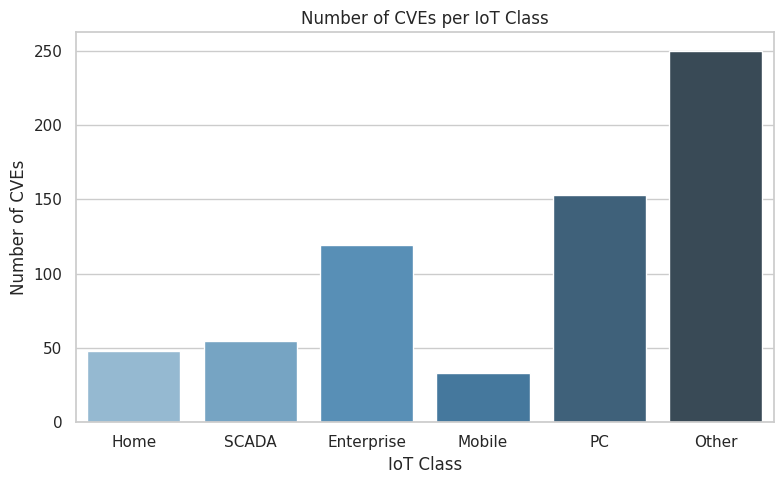

In [76]:
# ==================== PLOT CVE DISTRIBUTION ====================
from matplotlib import pyplot as plt


sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))



sns.barplot(
    data=dist_counts_vendor, 
    x="IoT_Class",
    y="Count",
    order=dist_counts_vendor["IoT_Class"],  # keep the order from your table
    palette="Blues_d"
)

plt.title("Number of CVEs per IoT Class")
plt.xlabel("IoT Class")
plt.ylabel("Number of CVEs")
plt.xticks(rotation=0)  # rotate if labels are long
plt.tight_layout()
plt.show()

#### I can see that my prector has improved, by extracting the both the vendor and prodcut names from the CVE <br> But i still need better way to reduce the bios towards "Other" and some false positive

In [82]:
# ==================== SAVE FINAL DATASET AS CSV (SAFE) ====================
import pandas as pd
import csv

rows = []

for json_file in json_files:
    with open(json_file, "r", encoding="utf-8") as f:
        try:
            cve = json.load(f)
        except json.JSONDecodeError:
            continue

    desc = extract_description(cve)
    if not desc.strip():
        continue

    vendor, product = extract_vendor_product(cve)
    iot_class = enhanced_classify_cve(cve)

    rows.append({
        "id": json_file.stem,     # CVE ID
        "description": desc,      # FULL description (may contain newlines/tabs)
        "vendor": vendor,
        "product": product,
        "IoT_class": iot_class
    })

df = pd.DataFrame(rows)

# Optional but recommended: normalize whitespace for ML
df["description"] = df["description"].str.replace(r"\s+", " ", regex=True)

# SAFE CSV EXPORT (prevents column splitting)
df.to_csv(
    "cve_iot_dataset.csv",
    index=False,
    encoding="utf-8",
    quoting=csv.QUOTE_ALL,   # critical fix
    lineterminator="\n"     # <-- correct argument
)

print(f"Saved {len(df)} CVEs to cve_iot_dataset.csv")


Saved 658 CVEs to cve_iot_dataset.csv


## Problem 2 Using Machine learning
